# Elastic Potential Energy Heuristic for the Traveling Salesman Problem
## Originally created May, 2017.

<hr>
James Savino

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.path as plpath
import numpy as np
from numpy import linalg
import scipy
import scipy.spatial
import scipy.stats as ss
import tkinter
from scipy.spatial import ConvexHull
from scipy.spatial import distance
import random

## Introduction

Consider the work a traveling salesman does: They must move between cities, selling their goods, while keeping their expenses to an absolute minimum.  The Traveling Salesman Problem (TSP) seeks to find the optimal path between a given number of cities such that each city is visited just once.  At its core, the TSP is a minimization problem.

That said, all TSP problems fall into the NP-Hard category, meaning that it is incredibly difficult and time-consuming to solve, especially as the number of points increases.  An exact solution to the TSP that can be found in polynomial time would have lasting repercussions in computer science.  This algorithm seeks to estimate solutions to the TSP in euclidean space by applying pressure to an elastic band.

My approach to the TSP started with my own solutions done by hand.  It's been noted that humans are particularly good at solving the TSP, and I believe this is because we start with the convex hull, which is the polygon with the fewest vertices made up of a set of points that contains all other points in the set.  Imagine having a bunch of pegs attached to a platform and placing a rubber band around all of them.  The rubber band would create the convex hull.

Let's take a look at a convex hull for some random points.

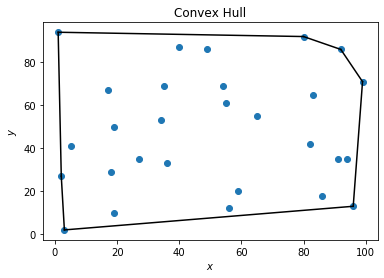

In [48]:
#This determines the number of points.  Minimum of 10 and maximum of 30.
num = random.randint(10, 30)
#Generate 'num' random x and y coordinates.
x = np.random.randint(1, 100, num)
y = np.random.randint(1, 100, num)

#Put coordinates into a 2-dimensional numpy array
pts = np.column_stack((x,y))

#Create the convex hull.
hull = ConvexHull(pts)

#Plot the convex hull.
plt.plot(pts[:,0], pts[:,1], 'o')
plt.title('Convex Hull')
plt.xlabel('$x$')
plt.ylabel('$y$')
for simplex in hull.simplices:
    plt.plot(pts[simplex, 0], pts[simplex, 1], '-k')
plt.show()

As is quite obvious, the convex hull encompasses all points and uses points of the set as vertices.  It's interesting to note that for a given TSP set where the points are the vertices of the convex hull, then the convex hull is the solution to the TSP.

### Elastic Potential Energy

The rubber band analogy extends further than just the convex hull.  Consider the application of pressure to the rubber band in two dimensions.  The band will slowly collapse inward and, after a certain period of time, it will have touched every single point in the set. The assumption made in this model is the state with the lowest potential energy will also yield the shortest path.


This should be quite clear, when considering the equation for elastic potential energy, which is derived from Hooke's Law:
$$U = \frac{1}{2}kx^2$$


Of particular interest here is the spring constant and x.  Let's explore what these variables mean in the context of the collapsing rubberband.


x: When the band is stretched taut and a force is applied perpendicular to its length, then the perpendicular displacement is x.
k: This is the spring constant.  Now, an important thing to note about the spring constant is that it varies depending on the length of the spring.

#### The Spring Constant

Consider a large spring with a spring constant of k.  This means its potential energy can be defined as such:
$$U_0 = \frac{1}{2}k_0x_0^2$$

Now, let's say the spring is split in half.  And each part is stretched such that the total potential energy among them is the same.  Then:
$$U_0 = 2\times \frac{1}{2}k_1 \frac{x_0^2}{4} = \frac{1}{2}k_0x_0^2$$

By canceling the the relevant terms and rearranging the equation, we find that:
$$k_0 = \frac{k_1}{2}$$

This can be repeated with any number of subdivisions.  What's important to note here is that the value of k is dependent on the length of the band, assuming the band is uniform.  This fact will be exploited in the algorithm, which allows longer sections of the convex hull to collapse at a faster rate due to the smaller spring constant on that section.  The assumption here is that, while it's the same spring, and the spring constant is relative to the length, the band is fixed at at vertex, so each line has its own potential energy.

Going back to the potential energy equation, let's assume that the base length is $L_0$, new length is $L_1$.  We will multiply both sides by L.

$$Lk_0 = L_1k_1$$

In this model, we assume $L_0 = 1$ and $k_0 = 1$, which allows us to say $k_i = \frac{1}{L_i}$

We can then plug this into the potential energy equation and solve for x.
$$x = \sqrt{2UL_i}$$

This is how far the band will be displaced given a potential energy and length, assuming $k_0 = 1$ and $L_0 = 1$.

<hr>

Let's load the functions that make up the algorithm.  Feel free to read the comments and docstrings on them.

In [49]:
def getlinedata(hv,centroid):
    '''
    Computes important line data for purposes of creating pseudo vertices, which
    are used to create a temporary polygon to capture new points.
    Args:
        hv: the hull vertices
        centroid: the "center of mass" of the points.
    returns:
        lens: lengths of each line in the original hull
        slopes: slopes of each line in the original hull
        pslopes: slopes that go from the midpoint of each line in the original hull toward the centroid
        midpts: the midpoints of each line.
    '''
    #Initialize the arrays
    lens = []
    slopes = []
    pslopes = []
    mpx = []
    mpy = []
    #Append the first hull point to the bottom of the list to make calculations easier.
    hv = np.vstack((hv,hv[0]))
    #Get slopes.
    for i in range(len(hv)-1):
        x1 = hv[i, 0]
        x2 = hv[i+1, 0]
        y1 = hv[i, 1]
        y2 = hv[i+1, 1]
        d = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        mpx.append((x1+x2)/2)
        mpy.append((y1+y2)/2)
        if (x2-x1) != 0:
            slope = (y2-y1)/(x2-x1)
        #If the slope is undefined, then just make it 9999.
        else:
            slope = 9999
        slopes.append(slope)
        lens.append(d)
    #Get slopes to point to the edges of the triangles.
    for i in range(len(slopes)):
        x1 = hv[i, 0]
        x2 = centroid[0,0]
        y1 = hv[i, 1]
        y2 = centroid[0,1]
        if (x2-x1) != 0:
            slope = (y2-y1)/(x2-x1)
        #If the slope is undefined, then just make it 9999.
        else:
            slope = 9999
        pslopes.append(slope)
    #Get the midpoints.
    midpts = np.column_stack((mpx, mpy))
    return lens, slopes, pslopes, midpts;

def InteriorCentroid(x,y):
    '''
    Finds the centroid of interior points that are not part of the hull.
    Args:
        x: the values
        y: the y values
    Returns:
        center: the centroid
    '''
    #Get the mean of x and y coordinates.
    xavg = np.mean(x)
    yavg = np.mean(y)
    #Get the centroid.
    center = np.column_stack((xavg, yavg))
    return center

def PseudoVertices(u, pslopes, midpoints, centroid, lens):
    '''
    Creates "pseudo" vertices for the encroaching polygon.  This is based off of elastic potential energy.
    Args: u, pslopes, midpoints, centroid, lens
    '''
    #Initialize variables.
    xps = []
    yps = []
    #Generate the vertices.
    for i in range(len(midpoints)):
        #This is the distance that each vertice may extend from the original hull's midpoint.
        #This is derived from the potential energy of a spring: u = 1/2kx^2
        d = np.sqrt(2*u*lens[i])
        #Get the change in x and y.
        deltax = d/np.sqrt(pslopes[i]**2+1)
        deltay = deltax*pslopes[i]
        #Get the points on both sides +- slope.
        xpsadd = midpoints[i,0]+deltax
        xpsmin = midpoints[i,0]-deltax
        ypsadd = midpoints[i,1]+deltay
        ypsmin = midpoints[i,1]-deltay
        #Find the distance for each type from the centroid.
        disadd = np.sqrt((centroid[:,0]-xpsadd)**2 + (centroid[:,1]-ypsadd)**2)
        dismin = np.sqrt((centroid[:,0]-xpsmin)**2 + (centroid[:,1]-ypsmin)**2)
        #Pick the vertex that is closest to the centroid.
        if disadd < dismin:
            xps.append(xpsadd)
            yps.append(ypsadd)
        else:
            xps.append(xpsmin)
            yps.append(ypsmin)
    #Stack into one numpy array.
    psverts = np.column_stack((xps,yps))
    return psverts

def NewHull(hvm,psverts):
    '''
    Generates the pseudo hull from the list of original hull points and pseudo vertices.
    Args:
        hvm: the original hull vertices
        psverts: the pseudo vertices
    Returns:
        pseudohull: the new pseudo hull.
    '''
    #Initialize lists.
    x = []
    y = []
    #Add the pseudo vertices to the old hull.  Note, they have the same indexing, since psverts was
    #Calculated from the original hull.  Just add the new vertices after.
    for i in range(len(hvm)):
        x.append(hvm[i,0])
        x.append(psverts[i,0])
        y.append(hvm[i,1])
        y.append(psverts[i,1])
    pseudohull = np.column_stack((x,y))
    return pseudohull

def DistanceTwoPoints(a,b):
    '''
    Calculates the distance between two points.
    Args:
        a,b: the points
    Returns:
        The distance
    '''
    return np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)

def AttachPoints(heldptsindex,hvm,heldpoints,distanceindex):
    '''
    Attaches points points to the new hull according to where they are in accordance with the existing hull and pseudohull.
    Args:
        heldptsindex: This says what triangle created by the normal hull and two lines created by the pseudo vertices
        the particular point fell into.
        hvm: This is the original hull.
        heldpoints: These are the coordinates for the held points.
        distanceindex: This gives the index and distance to the nearest vertex for the heldpoints.
    Returns:
        hvm: The new hull.
    '''
    #Get some more data.  This gives us some more information regarding the nearest hull point to the held point.
    hulldistance = CheckDistance(heldpoints,hvm)
    #Combine all the data and sort it on the correct columns.  It's important that indexes are in the
    #Correct order or they won't add correctly due to shifting.
    pointswdis = np.column_stack((heldptsindex, hulldistance[0], distanceindex[1], heldpoints))
    pointswdis = pointswdis[np.lexsort((hulldistance[1], distanceindex[1], distanceindex[0]))]
    #Initialize our variable and list.
    j = 1
    newhvmx = []
    newhvmy = []
    #Add the points.
    for i in range(len(pointswdis)):
        x = pointswdis[i,3]
        y = pointswdis[i,4]
        ind = pointswdis[i,0]+j
        #If it tries to add it as the last point, then just subtract one to make it add properly.
        if ind > len(hvm):
            ind = ind-1
        #Isert the points.
        hvm = np.insert(hvm,ind,[x,y], axis=0)
        #Add j because all indexes shift by 1.
        j = j+1
    return hvm

def CheckPoints(interiorpoints,pseudohull):
    '''
    Checks if points are inside of the pseudohull or not.
    Args:
        interiorpoints: the points that are not currently part of the hull
        pseudohull: the pseudohull
    Returns:
        inside: Array with boolean values at that describes whether a point is inside or outside of the 
        hull by its index.
    '''
    #Define the path.
    path = plpath.Path(pseudohull)
    #Check if the points are inside or not.
    inside = path.contains_points(interiorpoints)
    return inside

def CheckDistance(heldpoints,psverts):
    '''
    Gets distance from pseudo hull vertices for points that are outside of the pseudo hull.
    Args:
        heldpoints: the points outside the pseudohull, but not part of the main hull.
        psverts: the pseudo  vertices.
    Returns:
        distanceind: index of the closest pseudo vertex to the held point at the indx.
        distancefromint: distance of the closest pseudo vertex to the held point at the index.
    '''
    #Initialize the lists.
    distanceind = []
    distancefrom = []
    #Find the distances and index the smallest ones.
    for i in range(len(heldpoints)):
        distance = []
        for j in range(len(psverts)):
            distance.append(np.linalg.norm(psverts[j] - heldpoints[i]))
        distanceind.append(distance.index(min(distance)))
        distancefrom.append(min(distance))
    #Multiply distances by 100 so they can be made into integers with minimal rounding error.
    distancefrom = [i*100 for i in distancefrom]
    #Convert into integers.
    distancefromint = [int(distancefrom) for distancefrom in distancefrom]
    return distanceind, distancefromint

def HeldPoints(inside, interiorpoints):
    '''
    Gets points that are not part of the hull and are also not inside of the pseudo hull.
    Args:
        inside: truth values for if points are inside the hull or not.
        interiorpoints: list of points that are not part of the hull.
    Returns:
        heldpoints: the points outside the pseudohull, but not part of the hull.  These are the ones
        that are to be added to the main hull.
        interiorpoints: the points inside the pseudohull
    '''
    #Make truth array into list.
    listpy = np.array(inside).tolist()
    #Get indices for appropriate points.
    listpyindex = [i for i, x in enumerate(listpy) if x == False]
    #Initialize the lists.
    heldpointsx = []
    heldpointsy = []
    #Create list of held points.
    for i in listpyindex:
        heldpointsx.append(interiorpoints[i,0])
        heldpointsy.append(interiorpoints[i,1])
    #Create held points array and interior points array, with is the current array minus held points.
    heldpoints = np.column_stack((heldpointsx,heldpointsy))
    interiorpoints = np.delete(interiorpoints,listpyindex,axis=0)
    return heldpoints, interiorpoints

def HeldCheck(hvm,pseudohull, heldpoints):
    '''
    Checks what triangle created by the pseudo hull and main hull the held points fall into.
    Args:
        hvm: The main hull
        pseudohull: The pseudo hull
        heldpoints: the held points.
    Returns:
        heldptsindex: the index of the hull vertice that is counter-clockwise adjacent to the held point.
    '''
    #Initialize list.
    heldptsindex = []
    #Get array for half the number of vertices, minus one.
    r = int(len(pseudohull)/2)-1
    #For all held points, check if they are inside the triangle.  If they are, then index them.
    for i in range(len(heldpoints)):
        #Initialize boolean variables and indexing variable.
        a = False
        b = False
        k = 0
        #Check each point in each triangle.
        for j in range(r):
            #Create triangles out of two hull points and a pseudo hull vertex.
            path = plpath.Path([pseudohull[k], pseudohull[k+1], pseudohull[k+2]])
            #Add the point if it's inside.  The second check is a protection from adding points multiple times.
            if path.contains_point(heldpoints[i]) == True and len(heldptsindex) < len(heldpoints):
                heldptsindex.append(int(k/2))
                #Change truth value to true.
                a = True
            #Increment the index value by 2 because index is relative to the main hull, not the pseudo hull.
            k = k+2
        #Due to the way k is added, this is the final triangle.  Otherwise, it'd run out of the index.
        path = plpath.Path([pseudohull[-2], pseudohull[-1], pseudohull[0]])
        if path.contains_point(heldpoints[i]) == True and len(heldptsindex) < len(heldpoints):
            heldptsindex.append(int((k)/2))
            #Change truth value to true.
            b = True
        #If the point wasn't captured in any polygon, then just index it to the closest point on the main hull.
        if a == False and b == False and len(heldptsindex) < len(heldpoints):
            X = CheckDistance(heldpoints[i],hvm)[0]
            heldptsindex.append(X[1])
    return heldptsindex

def getlinedatalast(hv):
    '''
    Gets line data for phase 2.  This one makes the slopes for the pseudo vertices perpendicular instead
    of pointing them at the centroid.  It allows capture of points which may have evaded the centroid method.
    Args:
        hv: the hull points.
    Returns:
        lens: lengths of each line in the original hull
        slopes: slopes of each line in the original hull
        pslopes: slopes perpendicular to each line making up the hull.
        midpts: the midpoints of each line.
    '''
    #Initialize lists.
    lens = []
    slopes = []
    pslopes = []
    mpx = []
    mpy = []
    #Append the first hull point to the bottom of the list to make calculations easier.
    hv = np.vstack((hv,hv[0]))
    #Get slopes.
    for i in range(len(hv)-1):
        x1 = hv[i, 0]
        x2 = hv[i+1, 0]
        y1 = hv[i, 1]
        y2 = hv[i+1, 1]
        d = np.sqrt((x2-x1)**2 + (y2-y1)**2)
        mpx.append((x1+x2)/2)
        mpy.append((y1+y2)/2)
        if (x2-x1) != 0:
            slope = (y2-y1)/(x2-x1)
        #If slope is undefined, make it 9999.
        else:
            slope = 9999
        slopes.append(slope)
        lens.append(d)
    #Get perpendicular slopes.
    for i in range(len(slopes)):
        if slopes[i] != 0:
            pslopes.append(-1/slopes[i])
        #If slope is undefined, make it 9999
        else:
            pslopes.append(9999)
    #Get midpoints.
    midpts = np.column_stack((mpx, mpy))
    return lens, slopes, pslopes, midpts;

def perimeter(hvm):
    '''
    Calculates the length of the path.
    Args:
        hvm: the final path.
    Returns:
        The length.
    '''
    #Append the first hull point to the bottom of the list to make calculations easier.
    hvm = np.vstack((hvm,hvm[0]))
    #Initialize list.
    distances = []
    #Turn into np array.
    hvm = np.asarray(hvm)
    #Get lengths of each line.
    for i in range((len(hvm)-1)):
        distance = np.sqrt((hvm[i,0]-hvm[i+1,0])**2+(hvm[i,1]-hvm[i+1,1])**2)
        distances.append(distance)
    #Return the sum of the lengths.
    return np.sum(distances)

def addfinalpoints(interiorpoints,hvm):
    '''
    If points are not picked up in the maximum number of runs, then this adds them according to distance indexing.
    Args:
        interiorpoints: the points that still need to be added.
        hvm: the hull vertices
    '''
    #Get the closest hull points to each interior point.
    distanceind, distance = CheckDistance(interiorpoints,hvm)
    #Initialize indexing variable.
    j = 0
    #Add the points according to the closest hull vertex.
    for i in range(len(interiorpoints)):
        x = interiorpoints[i,0]
        y = interiorpoints[i,1]
        ind = distanceind[i]+j
        #Safe guard if the closest hull vertex is the last one.
        if ind > len(hvm):
            ind = ind-1
        #Inserts points at appropriate index.
        hvm = np.insert(hvm,ind,[x,y], axis=0)
        j = j+1
    return hvm
        
    
def MainFunction(num,x,y,alpha1,alpha2,beta,gamma):
    '''
    This is the main function.  It combines the other functions and creates a solution to the TSP.
    Args:
        num: Number of points.
        x: x coordinates for points.
        y: y coordinates for points.
        alpha1: parameter for the number of iterations done in phase 1.
        alpha2: parameter for the number of iterations done in phase 2.
        beta: parameter for the total number of iterations.
        gamma: parameter for the starting value of potential energy.
    Returns:
        hvm: The new hull.
        newhullprnt: A printable version of the new hull with the first entry at the beginning and end.
        pts: An array for the points of the city.
        hull: The original hull
        pseudohullprnt: The final pseudo hull (for troubleshooting)
    '''
    #Put coordinates into a 2-dimensional numpy array
    pts = np.column_stack((x,y))

    #Create the convex hull.
    hull = ConvexHull(pts)

    #hull.vertices returns the indices for the vertices.  This creates a new array with the coordinates of the vertices.
    hvm = pts[hull.vertices]
    #create hull index
    hullindex = hull.vertices
    #clone array of all points, and then delete the hull vertices to generate an array of only interior points.
    interiorpoints = np.delete(pts, hullindex, axis=0)
    #initialize variables.
    w = 0
    j = 0
    r = 1
    #Exterior loop.  Runs until the appropriate number of iterations are done or all points are accounted for.
    while w != num:
        #Initialize variables.
        v = 1
        centroid = InteriorCentroid(interiorpoints[:,0], interiorpoints[:,1])
        old = 0
        new = 0
        c = 1
        #Phase 1 loop.  This uses the centroid.  Deprecated.
        while c < r*alpha1:
            #Set old to new to start.  This is the default state, where v increments by 1.
            old = new
            #Get the line data.
            lengths,slopes,pslopes,midpoints = getlinedata(hvm,centroid)
            #Get the potential energy.  This is multiplied by v, so it increases with each iteration.
            u = gamma*v/(np.mean(lengths))
            #Get the pseudo vertices.
            psverts = PseudoVertices(u, pslopes,midpoints, centroid, lengths)
            #Make the pseudo hull.
            pseudohull = NewHull(hvm,psverts)
            #Check if points are inside the pseudo hull.
            inside = CheckPoints(interiorpoints,pseudohull)
            #Get held points, which are to be added to the main path.
            heldpoints,interiorpoints = HeldPoints(inside, interiorpoints)
            #Get distance data for held points to pseudo vertices.
            distanceindex = CheckDistance(heldpoints, psverts)
            #Get the indices what triangles made by the pseudo hull and main hull that the held points fall into.
            heldptsindex = HeldCheck(hvm,pseudohull, heldpoints)
            #Create a pseudohull for matplotlib.  For troubleshooting.
            #pseudohullprnt = np.vstack((pseudohull,pseudohull[0]))
            #Create new path/hull.
            hvm = AttachPoints(heldptsindex,hvm,heldpoints,distanceindex)
            #Create a path for matplotlib.  For troubleshooting.
            newhullprnt = np.vstack((hvm,hvm[0]))
            #Get length of new path.
            new = len(hvm)
            #v = v+1
            #If no new points have been added, increase v by one.
            if new == old:
                v = v+1
            #If new points have bene added, reset v to 1.
            else:
                v = 1
            #Calculate new centroid.
            centroid = InteriorCentroid(interiorpoints[:,0], interiorpoints[:,1])
            #Increment control variable.
            c = c+1
        #Print statments for status of run.
        print('...Done with part 1.  It required {} iterations.' .format(c))
        print('...There are {} points remaining.  Reinitializing variables and starting phase 2.' .format(len(pts)-len(hvm)))
        #Initialize variables.
        c = 1
        l = 1
        v = 1
        old = 0
        new = 0
        #Check to see if exterior loop should be broken.
        l = len(interiorpoints)
        if l == 0:
            break
        #Phase 2 loop.  Uses perpendicular slopes for the pseudo vertices.
        while c < r*alpha2:
            #Set old to new to start.  This is the default state, where v increments by 1.
            old = new
            #Get the line data.
            lengths,slopes,pslopes,midpoints = getlinedatalast(hvm)
            #Set the potential energy.
            u = gamma*v/(np.mean(lengths))
            #Get the pseudo vertices.
            psverts = PseudoVertices(u, pslopes,midpoints, centroid, lengths)
            #Make the pseudo hull.
            pseudohull = NewHull(hvm,psverts)
            #Check if points are inside the pseudo hull or not.
            inside = CheckPoints(interiorpoints,pseudohull)
            #Get the held points.
            heldpoints,interiorpoints = HeldPoints(inside, interiorpoints)
            #Get index of closest pseudo vertices.
            distanceindex = CheckDistance(heldpoints, psverts)
            #Get the indices of triangles made by the pseudo hull and main hull that the held points fall into.
            heldptsindex = HeldCheck(hvm,pseudohull, heldpoints)
            #pseudohullprnt = np.vstack((pseudohull,pseudohull[0]))
            #Generate new path/hull.
            hvm = AttachPoints(heldptsindex,hvm,heldpoints,distanceindex)
            newhullprnt = np.vstack((hvm,hvm[0]))
            #Set new to the length of the path.
            new = len(hvm)
            #Incremement control variable.
            c = c+1
            #v = v+1
            #If no new points have been added, increase v by 1.
            if new == old:
                v = v+1
            #If new points have been added, then reset v to 1.
            else:
                v = 1
            l = len(interiorpoints)
            #Get centroid.
            if l != 0:
                centroid = InteriorCentroid(interiorpoints[:,0], interiorpoints[:,1])
        #Break the exterior loop if all points are accounted for.
        if l == 0:
            break
        #Print statements for status.
        print('...Done with part 2.  It required {} iterations.' .format(c))
        print('...There are {} points remaining.  Reinitializing variables and restarting phase 1.' .format(len(pts)-len(hvm)))
        #Incremement control variable for exterior loop.
        j = j+c*2
        #Get length of path to check exterior loop.
        w = len(hvm)
        #Incremement r to increase number of iterations for each phase.
        r = r+1
        #Break exterior loop if a certain number of iterations have fun.
        if j > beta:
            break
    #If the loop breaks and points still exist, index them according to the closest hull points.
    if l !=0:
        hvm = addfinalpoints(interiorpoints, hvm)
        newhullprnt = np.vstack((hvm,hvm[0]))
    print('Solution Complete.  Please view below.')
    return hvm,newhullprnt,pts,hull,pseudohullprnt

## The Algorithm

The algorithm uses the idea of a collapsing rubber band to minimize the path length for the TSP.  Let's go over how the algorithm works.

The first thing the algorithm does is create the convex hull, as shown above.  

The second step is to get important data for the points and convex hull.  What it does, is get the slopes of the hull faces, the centroid, and determines slopes for the pseudo hull, which is created in step 3.  The pseudo hull can have two different slopes depending on the phase.  In phase 1, the slopes point toward the centroid, whereas in phase 2, the slopes are perpendicular to the hull faces, creating equilateral triangles.  Note: Use of centroid method is no longer used, but kept is currently kept in the code for reference.

The third thing the algorithm does is create something called a pseudo hull.  This is created based on the potential energy budget, which is calculated using this equation:

$$U = \frac{\gamma \times i}{\bar L}$$

Where $\bar L$ is the average length for all edges on the hull, $i$ is the number of iterations, $\gamma$ is a scaling factor.

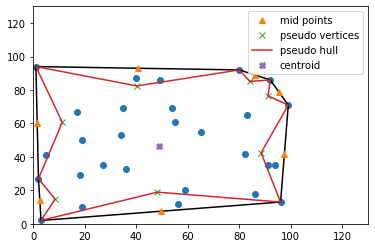

In [50]:
#hull.vertices returns the indices for the vertices.  This creates a new array with the coordinates of the vertices.
hvm = pts[hull.vertices]
#create hull index
hullindex = hull.vertices
#clone array of all points, and then delete the hull vertices to generate an array of only interior points.
interiorpoints = np.delete(pts, hullindex, axis=0)
centroid = InteriorCentroid(interiorpoints[:,0], interiorpoints[:,1])
lengths,slopes,pslopes,midpoints = getlinedatalast(hvm)
#Get the potential energy.  This is multiplied by v, so it increases with each iteration.
gamma = 5
u = gamma*50/(np.mean(lengths)*len(lengths))
#Get the pseudo vertices.
psverts = PseudoVertices(u, pslopes,midpoints, centroid, lengths)
#Make the pseudo hull.
pseudohull = NewHull(hvm,psverts)
pseudohullprnt = np.vstack((pseudohull,pseudohull[0]))

plt.plot(pts[:,0], pts[:,1], 'o')
axes = plt.gca()
axes.set_xlim([0,130])
axes.set_ylim([0,130])
for simplex in hull.simplices:
    plt.plot(pts[simplex, 0], pts[simplex, 1], '-k')
plt.plot(midpoints[:,0], midpoints[:,1], '^', label='mid points')
plt.plot(psverts[:,0], psverts[:,1], 'x', label = 'pseudo vertices')
plt.plot(pseudohullprnt[:,0], pseudohullprnt[:,1], '-', label = 'pseudo hull')
plt.plot(centroid[:,0], centroid[:,1], 'X', label = 'centroid')
plt.legend(loc = 'best')
plt.show()


What the algorithm does is capture the points that are inside the triangles created by the pseudo hull and the convex hull.  These points are then added to the main hull, and the process continues.  If no points are added to the pseudo hull after one iteration, the potential energy increases, and then the points are checked again.  The number of total iterations is determined by the parameter $\beta$ and the iterations for phase 1 is given by $\alpha_1$ and phase 2 by $\alpha_2$.  These can be adjusted to give better results for different situations.

## Issues

There are some issues with the algorithm.  The main one is that large clustering lends itself to errors.  That is, the more points there are per given area, the more likely the algorithm is to have a hiccup.  This is due to simplifications made to the algorithm.

The first major simplification is that it uses triangles for the pseudo hull.  This is an issue because points that fall right between two triangles will not be caught until later.  This can lead to self-intersecting polygons, which are inherently worse than full ones.  This is relatively rare, but happens enough that it needs to be corrected for the algorithm to be as effective as it can be.

The other simplification is that due to the way the path.contains_point function works in matplotlib, sometimes points on the edges are considered not inside the polygon and aren't picked up.  They are also not always picked up by an edge test because of issues with rounding floating point numbers.  Because of this, the algorithm needs to assign these points in some way, so I do it by checking which hull vertex the point is closest to and assigning it there.  This can lead to less-than-desirable results, including intersections or just silly paths.

These issues can be largely solved with correct parameterization based on number of number of points, size of the grid, number of clusters, and degree of clustering (bimodality coefficient?).  This is not currently implemented because it would require implementing calls to the Concorde TSP solver to determine error, which is too much work for now.

## Results

Let's see what happens when we run the algorithm.  Feel free to run the bottom cell multiple times.  It will give between 10 and 20 different points each time.

The parameters for this run are:

$\alpha_1 = 0$ - we no longer use the centroid method.

$\alpha_2 = 500$

$\beta = 15000$

$\gamma = .5$

These tend to yield good results and are what were used to test the algorithm against optimal solutions below.

...Done with part 1.  It required 1 iterations.
...There are 5 points remaining.  Reinitializing variables and starting phase 2.
...Done with part 2.  It required 500 iterations.
...There are 3 points remaining.  Reinitializing variables and restarting phase 1.
...Done with part 1.  It required 1 iterations.
...There are 3 points remaining.  Reinitializing variables and starting phase 2.
...Done with part 2.  It required 1000 iterations.
...There are 2 points remaining.  Reinitializing variables and restarting phase 1.
...Done with part 1.  It required 1 iterations.
...There are 2 points remaining.  Reinitializing variables and starting phase 2.
Solution Complete.  Please view below.


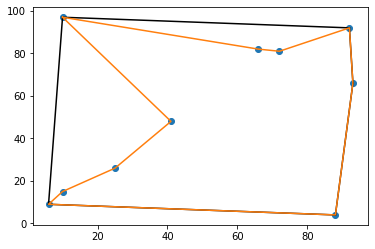

The perimeter is: 368.2530013943167


In [52]:
#This determines the number of points.  Minimum of 10 and maximum of 30.
num = random.randint(10, 20)
#num = 25
#Generate 'num' random x and y coordinates.
x = np.random.randint(1, 100, num)
y = np.random.randint(1, 100, num)
gamma = .5
beta = 15000
alpha1 = 0 #keep this 0.  Use of centroid is deprecated.
alpha2 = 500

hvm,newhullprnt,pts,hull,pseudohullprnt = MainFunction(num,x,y,alpha1,alpha2,beta,gamma)

plt.plot(pts[:,0], pts[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(pts[simplex, 0], pts[simplex, 1], '-k')
#plt.plot(midpoints[:,0], midpoints[:,1], '^')
#plt.plot(psverts[:,0], psverts[:,1], 'x')
#plt.plot(pseudohullprnt[:,0], pseudohullprnt[:,1], '-')
#plt.plot(centroid[:,0], centroid[:,1], 'X')
plt.plot(newhullprnt[:,0], newhullprnt[:,1], '-')

plt.show()
print('The perimeter is:', perimeter(hvm))

## How Accurate is the Algorithm?

There's an very useful resource for solving TSP problems called <a href="https://neos-server.org/neos/solvers/co:concorde/TSP.html">Concorde</a>.  I tested 24 different paths creating with my algorithm against the Concorde output, which uses more traditional methods to solve the TSP.  The main points of interest are the relative length, which is the algorithm's length divided by the optimal length, and number of cities.

The number of cities was selected randomly from a range of 10 to 30.  And the coordinates of the cities were randomized from 0 to 100 in both the x and y directions.  The parameters were as defined above.

Let's take a look at the data below.  There wasn't much, so it's just typed into the cell.

The mean relative length is: 1.0423


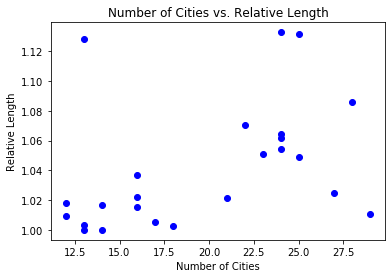

In [45]:
APath = np.array([427,338,495,326,430,380,465,300,278,394,296,393,369,314,499,453,291,469,325,455,392,447,507,352])
OPath = np.array([407,326,437,319,421,355,441,295,273,375,296,387,368,313,470,442,291,464,322,419,390,420,448,312])
Cities = np.array([25,16,24,16,21,22,24,14,12,23,14,16,18,13,24,27,13,29,12,28,17,24,25,13])
RLengths = APath/OPath
MRLengths = np.mean(RLengths)
print('The mean relative length is: {:.4F}' .format(MRLengths))

plt.title('Number of Cities vs. Relative Length')
plt.xlabel('Number of Cities')
plt.ylabel('Relative Length')
plt.plot(Cities,RLengths, 'bo')
plt.show()

The mean relative length for the 24 samples is 1.04, which means that the algorithm's path was 1.04 times larger than the optimal path, on average.  

It looks like there might be some correlation between the number (density) of the cities and the relative length.  Since these are matched pairs of data reflecting two different things, let's do Spearman's Correlation Test on it.  We'll set our $\alpha$ at 0.05, and the null hypothesis will be that the two sets of measurements are not correlated.

In [33]:
correlation, pvalue = ss.spearmanr(Cities,RLengths)
print('The Correlation is {:.4f} and the P-Value is {:.4f}' .format(correlation,pvalue))

The Correlation is 0.5184 and the P-Value is 0.0095


The P-Value is well under our $\alpha$ of 0.05, so we can reject the null hypothesis.  It seems like the two measurements come from the same distribution.  That tells us that as the density of points increases, the algorithm becomes less accurate.  It may be of interest to check to see how the relative length of the algorithm's path correlates with the area of the initial convex hull, as that'd tell more about whether it's the number of cities or the density of them that causes problems for the algorithm.

Going forward, one of the main issues with the algorithm is points being lost when in between triangles and self-intersection.  The elimination of these problems will likely result in much better results.

## Extra Fun.

If you're interested in the TSP and want to play around with the algorithm some more, you can uncomment the cell below, adjust the parameters, and play around with it.  There's also an output that will work in Concorde, linked below in Citations.  Just copy-paste the indicated data into notepad, save it as txt, and upload it to Concorde under the first option.  I wouldn't set beta to be above 20,000, but alpha1 and alpha2 can be adjusted, as can gamma.  If you want to mess around with the parameters to see if you get better results by changing them, you can run it once, and then comment out the num, x, and y lines, edit your paramaters, and then run the cell again.

In [21]:
'''#This determines the number of points.  Minimum of 10 and maximum of 30.
num = random.randint(10, 30)
#num = 25
#Generate 'num' random x and y coordinates.
x = np.random.randint(1, 100, num)
y = np.random.randint(1, 100, num)
gamma = 5
beta = 15000
alpha1 = 500
alpha2 = 500

hvm,newhullprnt,pts,hull,pseudohullprnt = MainFunction(num,x,y,alpha1,alpha2,beta,gamma)

plt.plot(pts[:,0], pts[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(pts[simplex, 0], pts[simplex, 1], '-k')
#plt.plot(midpoints[:,0], midpoints[:,1], '^')
#plt.plot(psverts[:,0], psverts[:,1], 'x')
#plt.plot(pseudohullprnt[:,0], pseudohullprnt[:,1], '-')
#plt.plot(centroid[:,0], centroid[:,1], 'X')
plt.plot(newhullprnt[:,0], newhullprnt[:,1], '-')

plt.show()
print('The perimeter is:', perimeter(hvm))
print('###COPY BELOW THIS POINT###')
print(len(pts))
for i in range(len(pts)):
    print(pts[i,0],pts[i,1])
print('###COPY ABOVE THIS POINT###')
'''
print('None')

None


### Citations

<a href="https://neos-server.org/neos/solvers/co:concorde/TSP.html">Hans Mittelmann. NEOS Server: Concorde, 2017</a>

<a href="http://sarielhp.org/research/CG/applets/tsp/TspAlg.html">Natasha, Kriemer.  Traveling Salesman Problem, 2017</a>

<a href="http://www.math.uwaterloo.ca/tsp/world/">World Traveling Salesman Problem, 2013</a>